<a href="https://colab.research.google.com/github/TirendazAcademy/Deep-Learning-with-PyTorch/blob/main/Cat_vs_Dog_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.7.1+cu126'

In [39]:
# Setup device-agnostic code
def check_cpu_gpu():
    return "cuda" if torch.cuda.is_available() else "cpu"
device = check_cpu_gpu()
device

'cuda'

# 1. Loading the dataset

In [ ]:
#!pip install opendatasets --upgrade --quiet

In [ ]:
#import opendatasets as od
#dataset_url = 'https://www.kaggle.com/datasets/tongpython/cat-and-dog'
#od.download(dataset_url)

100%|██████████| 218M/218M [00:10<00:00, 22.4MB/s]


# 2. Data Preparation

In [4]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

image_path = "resources/cat-and-dog"
walk_through_dir(image_path)

There are 2 directories and 0 images in 'resources/cat-and-dog'.
There are 2 directories and 0 images in 'resources/cat-and-dog/test_set'.
There are 0 directories and 1013 images in 'resources/cat-and-dog/test_set/dogs'.
There are 0 directories and 1012 images in 'resources/cat-and-dog/test_set/cats'.
There are 2 directories and 0 images in 'resources/cat-and-dog/training_set'.
There are 0 directories and 4006 images in 'resources/cat-and-dog/training_set/dogs'.
There are 0 directories and 4001 images in 'resources/cat-and-dog/training_set/cats'.


In [5]:
# Setup train and testing paths
train_dir = f"{image_path}/training_set/"
test_dir = f"{image_path}/test_set/"
train_dir, test_dir

('resources/cat-and-dog/training_set/', 'resources/cat-and-dog/test_set/')

In [10]:
import random
from PIL import Image
import glob
from pathlib import Path

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list= glob.glob(f"{image_path}/*/*/*.jpg")

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = Path(random_image_path).parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img.getcolors()

Random image path: resources/cat-and-dog/test_set/cats/cat.4944.jpg
Image class: cats
Image height: 375
Image width: 499


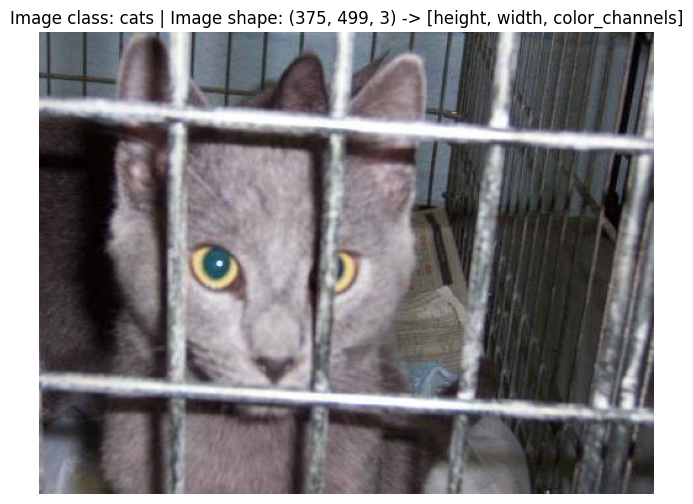

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# 3. Transforming data

In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 3.1 Transforming data with

In [15]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

resources/cat-and-dog/test_set/cats/cat.4944.jpg
resources/cat-and-dog/test_set/dogs/dog.4041.jpg
resources/cat-and-dog/training_set/dogs/dog.2246.jpg


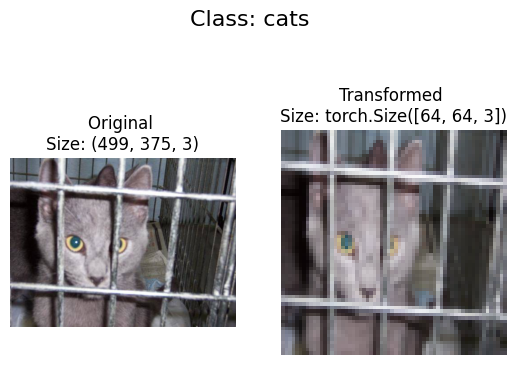

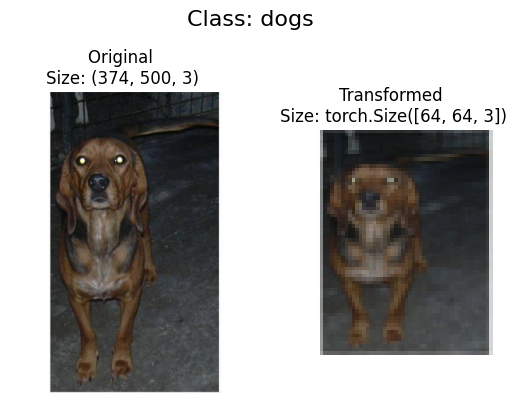

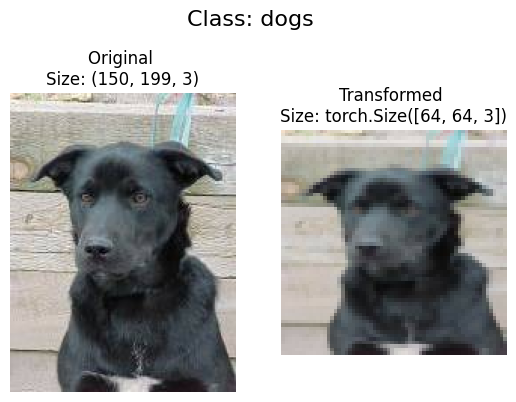

In [22]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        print(image_path)
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size + (len(f.getbands()), )}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(image_path).parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

# 4. Loading Image Data Using

In [23]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 8005
    Root location: resources/cat-and-dog/training_set/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2023
    Root location: resources/cat-and-dog/test_set/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [26]:
# Get class names as a list
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_names,  class_dict, len(train_data), len(test_data)

(['cats', 'dogs'], {'cats': 0, 'dogs': 1}, 8005, 2023)

In [27]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image shape: {img.shape}")
print(f"Image tensor:\n{img}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image shape: torch.Size([3, 64, 64])
Image tensor:
tensor([[[0.1529, 0.1686, 0.1686,  ..., 0.3176, 0.5059, 0.7647],
         [0.1451, 0.1490, 0.1725,  ..., 0.3216, 0.4941, 0.7686],
         [0.1451, 0.1412, 0.1804,  ..., 0.3294, 0.5020, 0.7882],
         ...,
         [0.0902, 0.0863, 0.0902,  ..., 0.2745, 0.3020, 0.2941],
         [0.0824, 0.0824, 0.0863,  ..., 0.2314, 0.2706, 0.2627],
         [0.0980, 0.0902, 0.0902,  ..., 0.3020, 0.2588, 0.1843]],

        [[0.1686, 0.1843, 0.1843,  ..., 0.3451, 0.5137, 0.7490],
         [0.1608, 0.1647, 0.1882,  ..., 0.3569, 0.5020, 0.7373],
         [0.1608, 0.1569, 0.1961,  ..., 0.3686, 0.5137, 0.7451],
         ...,
         [0.0902, 0.0863, 0.0902,  ..., 0.2235, 0.2392, 0.2353],
         [0.0784, 0.0784, 0.0824,  ..., 0.1647, 0.2039, 0.2078],
         [0.0902, 0.0824, 0.0824,  ..., 0.2353, 0.1961, 0.1333]],

        [[0.1647, 0.2039, 0.1922,  ..., 0.4314, 0.5137, 0.6471],
         [0.1569, 0.1843, 0.1961,  ..., 0.4431, 0.5098, 0.6549],
       

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


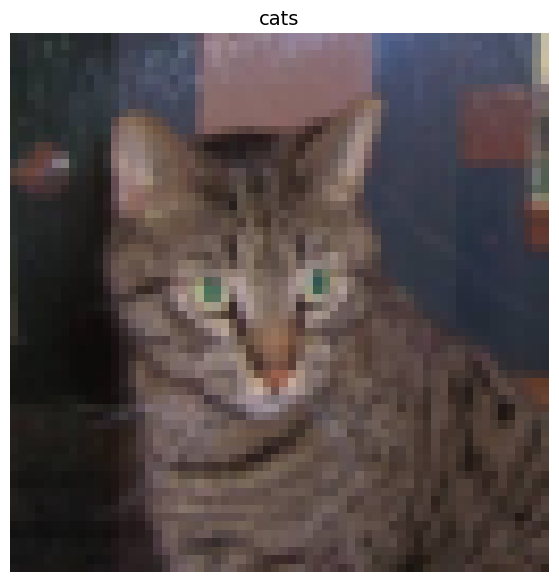

In [31]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

## 4.1 Turn loaded images into DataLoader's

In [32]:
# Turn train and test Datasets into DataLoaders
NUM_WORKERS = os.cpu_count()
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x74e265a8b130>,
 <torch.utils.data.dataloader.DataLoader at 0x74e265a8a350>)

In [33]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# 5. Model Building with Data Augmentation

## 5.1 Creating transforms and loading data

In [34]:
# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [35]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_augmented

(Dataset ImageFolder
     Number of datapoints: 8005
     Root location: resources/cat-and-dog/training_set/
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2023
     Root location: resources/cat-and-dog/test_set/
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [36]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(test_data_augmented, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_augmented

(<torch.utils.data.dataloader.DataLoader at 0x74e26598fcd0>,
 <torch.utils.data.dataloader.DataLoader at 0x74e2666255d0>)

## 5.2 Create TinyVGG model class

In [40]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
print(check_cpu_gpu(), device)
model = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model

cuda cuda


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=2, bias=True)
  )
)

## 5.3 Try a forward pass on a single image (to test the model)

In [41]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_augmented))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))
    NUM_WORKERS
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0517, 0.0569]], device='cuda:0')

Output prediction probabilities:
tensor([[0.4987, 0.5013]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
1


## 5.4 Understanding the model

In [43]:
# Install torchinfo if it's not available, import it if it is
# try: 
#     import torchinfo
# except:
#     !pip install torchinfo
#     import torchinfo
    
from torchinfo import summary
summary(model, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 5.5 Create train & test loop functions

In [46]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train modeNUM_WORKERS
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [47]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager so the backpropogation will not be calculated.
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## 5.6 Creating a train() function to combine train_step() and test_step()

In [48]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

## 5.7 Train and Evaluate Model

In [49]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Recreate an instance of TinyVGG
model = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(model=model, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_augmented,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  2%|▏         | 1/50 [00:02<01:47,  2.19s/it]

Epoch: 1 | train_loss: 0.6944 | train_acc: 0.5029 | test_loss: 0.6905 | test_acc: 0.5387


  4%|▍         | 2/50 [00:04<01:38,  2.05s/it]

Epoch: 2 | train_loss: 0.6904 | train_acc: 0.5394 | test_loss: 0.6796 | test_acc: 0.5898


  6%|▌         | 3/50 [00:06<01:34,  2.00s/it]

Epoch: 3 | train_loss: 0.6826 | train_acc: 0.5694 | test_loss: 0.6640 | test_acc: 0.6187


  8%|▊         | 4/50 [00:08<01:32,  2.00s/it]

Epoch: 4 | train_loss: 0.6632 | train_acc: 0.6026 | test_loss: 0.6520 | test_acc: 0.6440


 10%|█         | 5/50 [00:10<01:30,  2.00s/it]

Epoch: 5 | train_loss: 0.6477 | train_acc: 0.6186 | test_loss: 0.6271 | test_acc: 0.6561


 12%|█▏        | 6/50 [00:12<01:28,  2.01s/it]

Epoch: 6 | train_loss: 0.6275 | train_acc: 0.6476 | test_loss: 0.6176 | test_acc: 0.6627


 14%|█▍        | 7/50 [00:14<01:26,  2.01s/it]

Epoch: 7 | train_loss: 0.6188 | train_acc: 0.6562 | test_loss: 0.6017 | test_acc: 0.6662


 16%|█▌        | 8/50 [00:16<01:24,  2.01s/it]

Epoch: 8 | train_loss: 0.6131 | train_acc: 0.6652 | test_loss: 0.5764 | test_acc: 0.7033


 18%|█▊        | 9/50 [00:18<01:22,  2.01s/it]

Epoch: 9 | train_loss: 0.6107 | train_acc: 0.6647 | test_loss: 0.5704 | test_acc: 0.7005


 20%|██        | 10/50 [00:20<01:20,  2.00s/it]

Epoch: 10 | train_loss: 0.5974 | train_acc: 0.6779 | test_loss: 0.5777 | test_acc: 0.6966


 22%|██▏       | 11/50 [00:22<01:18,  2.00s/it]

Epoch: 11 | train_loss: 0.5905 | train_acc: 0.6786 | test_loss: 0.5952 | test_acc: 0.6662


 24%|██▍       | 12/50 [00:24<01:16,  2.01s/it]

Epoch: 12 | train_loss: 0.5813 | train_acc: 0.6910 | test_loss: 0.5536 | test_acc: 0.7201


 26%|██▌       | 13/50 [00:26<01:14,  2.02s/it]

Epoch: 13 | train_loss: 0.5785 | train_acc: 0.6899 | test_loss: 0.5685 | test_acc: 0.7088


 28%|██▊       | 14/50 [00:28<01:13,  2.03s/it]

Epoch: 14 | train_loss: 0.5759 | train_acc: 0.6900 | test_loss: 0.5479 | test_acc: 0.7213


 30%|███       | 15/50 [00:30<01:10,  2.02s/it]

Epoch: 15 | train_loss: 0.5665 | train_acc: 0.7068 | test_loss: 0.5478 | test_acc: 0.7208


 32%|███▏      | 16/50 [00:32<01:08,  2.03s/it]

Epoch: 16 | train_loss: 0.5667 | train_acc: 0.7014 | test_loss: 0.5415 | test_acc: 0.7272


 34%|███▍      | 17/50 [00:34<01:06,  2.02s/it]

Epoch: 17 | train_loss: 0.5650 | train_acc: 0.7056 | test_loss: 0.5321 | test_acc: 0.7326


 36%|███▌      | 18/50 [00:36<01:04,  2.00s/it]

Epoch: 18 | train_loss: 0.5676 | train_acc: 0.7034 | test_loss: 0.5367 | test_acc: 0.7272


 38%|███▊      | 19/50 [00:38<01:01,  1.99s/it]

Epoch: 19 | train_loss: 0.5611 | train_acc: 0.7121 | test_loss: 0.5381 | test_acc: 0.7296


 40%|████      | 20/50 [00:40<00:59,  1.99s/it]

Epoch: 20 | train_loss: 0.5585 | train_acc: 0.7068 | test_loss: 0.5377 | test_acc: 0.7357


 42%|████▏     | 21/50 [00:42<00:58,  2.02s/it]

Epoch: 21 | train_loss: 0.5609 | train_acc: 0.7088 | test_loss: 0.5303 | test_acc: 0.7362


 44%|████▍     | 22/50 [00:44<00:56,  2.02s/it]

Epoch: 22 | train_loss: 0.5459 | train_acc: 0.7199 | test_loss: 0.5400 | test_acc: 0.7324


 46%|████▌     | 23/50 [00:46<00:54,  2.01s/it]

Epoch: 23 | train_loss: 0.5559 | train_acc: 0.7127 | test_loss: 0.5244 | test_acc: 0.7450


 48%|████▊     | 24/50 [00:48<00:52,  2.02s/it]

Epoch: 24 | train_loss: 0.5533 | train_acc: 0.7106 | test_loss: 0.5174 | test_acc: 0.7411


 50%|█████     | 25/50 [00:50<00:50,  2.03s/it]

Epoch: 25 | train_loss: 0.5450 | train_acc: 0.7246 | test_loss: 0.5186 | test_acc: 0.7462


 52%|█████▏    | 26/50 [00:52<00:48,  2.02s/it]

Epoch: 26 | train_loss: 0.5475 | train_acc: 0.7193 | test_loss: 0.5070 | test_acc: 0.7540


 54%|█████▍    | 27/50 [00:54<00:46,  2.02s/it]

Epoch: 27 | train_loss: 0.5398 | train_acc: 0.7217 | test_loss: 0.5095 | test_acc: 0.7503


 56%|█████▌    | 28/50 [00:56<00:44,  2.01s/it]

Epoch: 28 | train_loss: 0.5421 | train_acc: 0.7216 | test_loss: 0.5176 | test_acc: 0.7492


 58%|█████▊    | 29/50 [00:58<00:42,  2.02s/it]

Epoch: 29 | train_loss: 0.5358 | train_acc: 0.7281 | test_loss: 0.5159 | test_acc: 0.7557


 60%|██████    | 30/50 [01:00<00:40,  2.01s/it]

Epoch: 30 | train_loss: 0.5451 | train_acc: 0.7135 | test_loss: 0.5217 | test_acc: 0.7494


 62%|██████▏   | 31/50 [01:02<00:38,  2.01s/it]

Epoch: 31 | train_loss: 0.5358 | train_acc: 0.7286 | test_loss: 0.5044 | test_acc: 0.7513


 64%|██████▍   | 32/50 [01:04<00:36,  2.02s/it]

Epoch: 32 | train_loss: 0.5371 | train_acc: 0.7237 | test_loss: 0.5109 | test_acc: 0.7494


 66%|██████▌   | 33/50 [01:06<00:34,  2.04s/it]

Epoch: 33 | train_loss: 0.5342 | train_acc: 0.7313 | test_loss: 0.5139 | test_acc: 0.7469


 68%|██████▊   | 34/50 [01:08<00:32,  2.04s/it]

Epoch: 34 | train_loss: 0.5373 | train_acc: 0.7271 | test_loss: 0.5142 | test_acc: 0.7423


 70%|███████   | 35/50 [01:10<00:30,  2.03s/it]

Epoch: 35 | train_loss: 0.5289 | train_acc: 0.7323 | test_loss: 0.5054 | test_acc: 0.7399


 72%|███████▏  | 36/50 [01:12<00:28,  2.01s/it]

Epoch: 36 | train_loss: 0.5282 | train_acc: 0.7386 | test_loss: 0.5012 | test_acc: 0.7489


 74%|███████▍  | 37/50 [01:14<00:26,  2.01s/it]

Epoch: 37 | train_loss: 0.5270 | train_acc: 0.7321 | test_loss: 0.5190 | test_acc: 0.7464


 76%|███████▌  | 38/50 [01:16<00:24,  2.00s/it]

Epoch: 38 | train_loss: 0.5283 | train_acc: 0.7352 | test_loss: 0.5067 | test_acc: 0.7531


 78%|███████▊  | 39/50 [01:18<00:22,  2.00s/it]

Epoch: 39 | train_loss: 0.5336 | train_acc: 0.7307 | test_loss: 0.5037 | test_acc: 0.7594


 80%|████████  | 40/50 [01:20<00:20,  2.02s/it]

Epoch: 40 | train_loss: 0.5339 | train_acc: 0.7288 | test_loss: 0.5126 | test_acc: 0.7609


 82%|████████▏ | 41/50 [01:22<00:18,  2.01s/it]

Epoch: 41 | train_loss: 0.5309 | train_acc: 0.7304 | test_loss: 0.5094 | test_acc: 0.7482


 84%|████████▍ | 42/50 [01:24<00:16,  2.01s/it]

Epoch: 42 | train_loss: 0.5360 | train_acc: 0.7282 | test_loss: 0.5081 | test_acc: 0.7540


 86%|████████▌ | 43/50 [01:26<00:14,  2.01s/it]

Epoch: 43 | train_loss: 0.5206 | train_acc: 0.7400 | test_loss: 0.5116 | test_acc: 0.7501


 88%|████████▊ | 44/50 [01:28<00:12,  2.00s/it]

Epoch: 44 | train_loss: 0.5301 | train_acc: 0.7335 | test_loss: 0.5022 | test_acc: 0.7516


 90%|█████████ | 45/50 [01:30<00:10,  2.01s/it]

Epoch: 45 | train_loss: 0.5216 | train_acc: 0.7385 | test_loss: 0.5079 | test_acc: 0.7540


 92%|█████████▏| 46/50 [01:32<00:08,  2.01s/it]

Epoch: 46 | train_loss: 0.5218 | train_acc: 0.7428 | test_loss: 0.4997 | test_acc: 0.7467


 94%|█████████▍| 47/50 [01:34<00:06,  2.01s/it]

Epoch: 47 | train_loss: 0.5302 | train_acc: 0.7272 | test_loss: 0.5040 | test_acc: 0.7516


 96%|█████████▌| 48/50 [01:36<00:04,  2.01s/it]

Epoch: 48 | train_loss: 0.5135 | train_acc: 0.7453 | test_loss: 0.5160 | test_acc: 0.7487


 98%|█████████▊| 49/50 [01:38<00:02,  2.02s/it]

Epoch: 49 | train_loss: 0.5244 | train_acc: 0.7410 | test_loss: 0.4996 | test_acc: 0.7628


100%|██████████| 50/50 [01:40<00:00,  2.02s/it]

Epoch: 50 | train_loss: 0.5222 | train_acc: 0.7368 | test_loss: 0.5033 | test_acc: 0.7604
Total training time: 100.754 seconds


## 5.8 Plot the loss curves of Model

In [50]:
# Check the model_0_results keys
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [51]:
def plot_loss_curves(results):
  
    results = dict(list(model_results.items()))
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

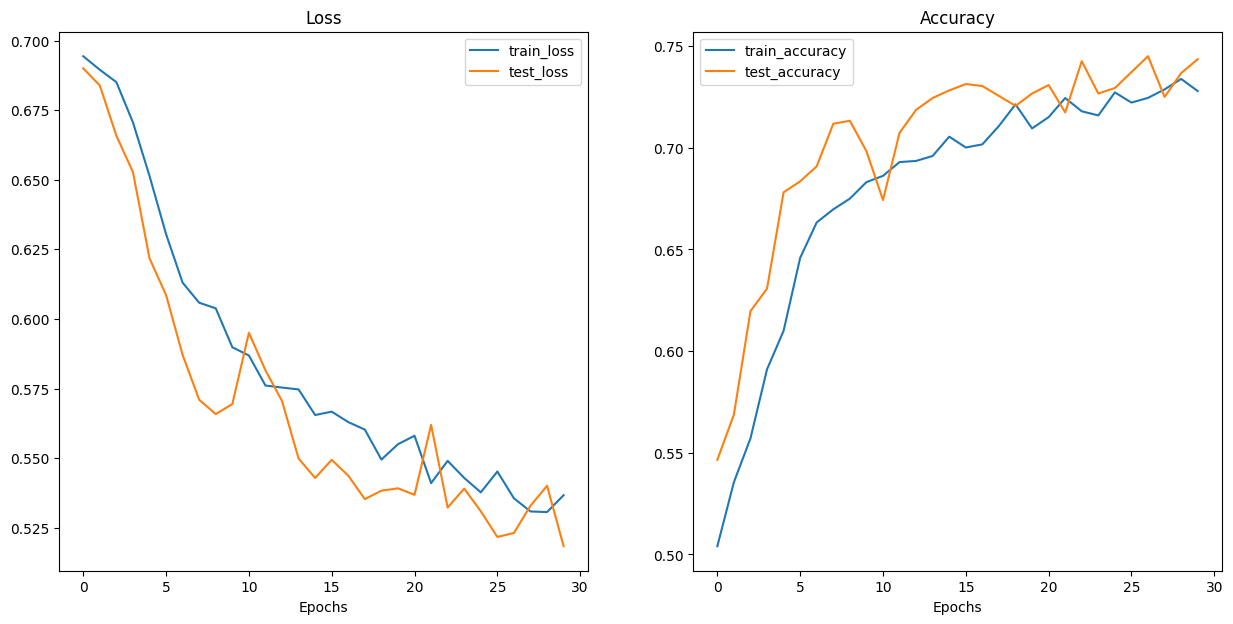

In [55]:
plot_loss_curves(model_results)

# 6. Make a prediction on a custom image

In [56]:
import torchvision
# Setup custom image path
custom_image_path = f"{image_path}/test_set/cats/cat.4001.jpg"
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.0471, 0.0118, 0.0863,  ..., 0.0118, 0.0078, 0.0039],
         [0.0000, 0.0431, 0.4196,  ..., 0.3451, 0.0078, 0.0039],
         [0.0431, 0.0627, 0.4549,  ..., 0.2549, 0.0078, 0.0039],
         ...,
         [0.0000, 0.0275, 0.3490,  ..., 0.1961, 0.0039, 0.0039],
         [0.0078, 0.0000, 0.0392,  ..., 0.0000, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0039, 0.0039]],

        [[0.0549, 0.0000, 0.0196,  ..., 0.0000, 0.0000, 0.0039],
         [0.0039, 0.0275, 0.3529,  ..., 0.3255, 0.0000, 0.0039],
         [0.0471, 0.0431, 0.3882,  ..., 0.2353, 0.0000, 0.0039],
         ...,
         [0.0235, 0.0431, 0.3412,  ..., 0.2039, 0.0039, 0.0039],
         [0.0471, 0.0118, 0.0431,  ..., 0.0078, 0.0039, 0.0039],
         [0.0157, 0.0431, 0.0039,  ..., 0.0314, 0.0039, 0.0039]],

        [[0.0353, 0.0000, 0.0588,  ..., 0.0000, 0.0118, 0.0118],
         [0.0000, 0.0235, 0.3843,  ..., 0.3412, 0.0118, 0.0118],
         [0.0235, 0.0314, 0.4118,  ..

In [57]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 415, 498])
New shape: torch.Size([3, 64, 64])


In [58]:
model.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [59]:
# Let's convert them from logits -> prediction probabilities -> prediction labels
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.0818, -0.1473]], device='cuda:0')
Prediction probabilities: tensor([[0.5570, 0.4430]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [61]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label] # put pred label to CPU, otherwise will error
custom_image_pred_class

'cats'

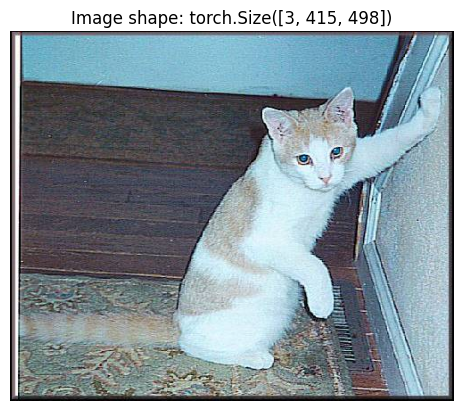

In [62]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);